# Stop and frisk under Mayor Bloomberg &mdash; Comparison of use-of-force

## Imports and dependencies

This notebook was written for Python3. It requires [Pandas](https://pandas.pydata.org/), [Matplotlib](https://matplotlib.org/), and [Seaborn](https://seaborn.pydata.org/).

All packages are available via conda:

```
$ conda install pandas seaborn matplotlib
```

In [1]:
%matplotlib inline

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_palette('colorblind')

os.chdir('/Users/msto/projects/stop-and-frisk')

## Data cleaning

The `Race` and `Date` columns were previously cleaned in the Stop and frisk animation notebook. We'll load those saved results here.

In [2]:
df = pd.read_csv('data/sqf.csv.gz')
df['Date'] = pd.to_datetime(df.Date)

/Users/msto/.miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,4,5,7,10,17,21,73,74,81,89,93,94,95,96,97,99,103,104,105,108,112,113,118,119,120,121,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There's no single column indicating whether force was used, but there are multiple boolean columns indicating whether the officer gave a reason that they used force. If any of these reasons are true, we'll say that the stop resulted in a use of force.

In [3]:
force_cols = [c for c in df.columns if c.startswith("pf_")]
df['Used_force'] = (df[force_cols] == 'Y').any(axis=1)

We'll bin the ages of each person stopped into ten year windows.

In [4]:
def get_age_range(age):
    if age < 15:
        return 'Under 15'
    elif age < 25:
        return '15-24'
    elif age < 35:
        return '25-34'
    elif age < 45:
        return '35-44'
    elif age < 55:
        return '45-54'
    else:
        return 'Over 55'

df['age_range'] = df.age.apply(get_age_range)

And we'll load the size of each demographic by the same ten year windows, obtained from [Baruch College](https://www.baruch.cuny.edu/nycdata/population-geography/pop-demography.htm).

In [5]:
pop = pd.read_csv('data/baruch/2016_male_pop_by_age_condensed.csv')

age_ranges = pop.age_range
races = ['WHITE', 'BLACK', 'HISPANIC']

pop = pd.melt(pop, id_vars=['age_range'], value_vars=races, 
              var_name='Race', value_name='Pop')\
        .set_index(['Race', 'age_range']).Pop

## Comparing use of force across race and age demographics

We'll select all the stops that resulted in NYPD use of force, group by race and age window, and count them.

In [6]:
idx = pd.MultiIndex.from_product(iterables=[races, age_ranges], names=['Race', 'age_range']) 

force = df.loc[df.Used_force]\
          .groupby(['Race', 'age_range'])\
          .size()\
          .reindex(idx)\
          .fillna(0)\
          .astype(int)

And we'll compute these counts as a percentage of the total number of people in NYC (as of 2016) of the same race and in the same age window.

In [7]:
pct_force = (force / pop).rename('Pct').reset_index()

Then we plot a simple bar chart to compare

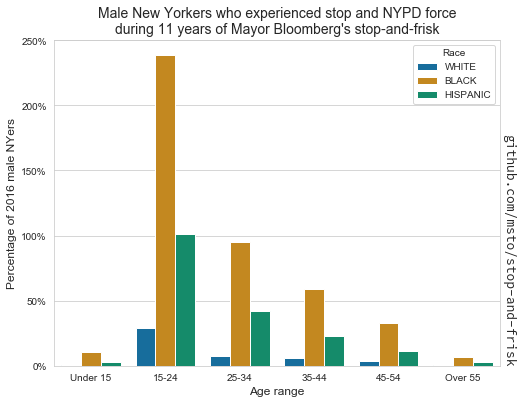

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(data=pct_force, y='Pct',
                 x='age_range', order=age_ranges,
                 hue='Race', hue_order=races)

# Clean up y-axis
ax.set_yticks(np.arange(0, 3, 0.5))
ax.set_yticklabels(['{0}%'.format(p) for p in range(0, 300, 50)])

# Labels
ax.set_xlabel("Age range", fontsize=12)
ax.set_ylabel("Percentage of 2016 male NYers", fontsize=12)
ax.set_title("Male New Yorkers who experienced stop and NYPD force\n"
             "during 11 years of Mayor Bloomberg's stop-and-frisk", fontsize=14)

# Citation
ax.text(1.0325, 0, 'github.com/msto/stop-and-frisk', 
        rotation=270,
        ha='right', va='bottom', fontsize=13,
        fontname='Source Code Pro', transform=ax.transAxes)

plt.savefig('figures/use_of_force_comparison.png', bbox_inches='tight')